Training set shape == (252, 6)
All timestamps == 252
Featured selected: ['Air', 'Land', 'Train', 'Sea', 'Total']
Shape of training set == (252, 5).
X_train shape == (181, 48, 4).
y_train shape == (181, 1).
Model: "sequential_5"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_10 (LSTM)               (None, 48, 32)            4736      
_________________________________________________________________
lstm_11 (LSTM)               (None, 64)                24832     
_________________________________________________________________
dense_5 (Dense)              (None, 1)                 65        
Total params: 29,633
Trainable params: 29,633
Non-trainable params: 0
_________________________________________________________________
Epoch 1/30
48/48 - 1s - loss: 0.1644 - val_loss: 0.3301
Epoch 2/30
48/48 - 0s - loss: 0.1438 - val_loss: 0.3236
Epoch 3/30
48/48 - 1s - loss: 0.1318 - val_loss: 0.3282
Epoch 

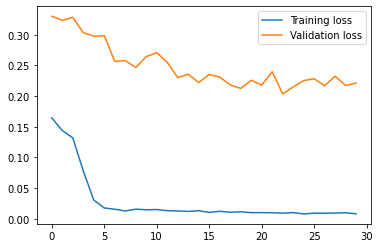

In [7]:
##Data Pre-processing
import numpy as np
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import datetime as dt
from datetime import datetime
from keras.callbacks import EarlyStopping, ReduceLROnPlateau, ModelCheckpoint, TensorBoard
from sklearn.preprocessing import RobustScaler
    ###Read data
    # Importing Training Set
dataset_train = pd.read_csv('Air_Land_Train_Sea.csv')
    
    # Select features (columns) to be involved intro training and predictions
cols = list(dataset_train)[1:6]
    
    # Extract dates (will be used in visualization)
datelist_train = list(dataset_train['Date'])
datelist_train = [dt.datetime.strptime(date, '%Y-%m').date() for date in datelist_train]
    
print('Training set shape == {}'.format(dataset_train.shape))
print('All timestamps == {}'.format(len(datelist_train)))
print('Featured selected: {}'.format(cols))
    
    ### Data pre-processing
dataset_train = dataset_train[cols].astype(str)
    
dataset_train= dataset_train.astype(float)
    
    # Using multiple features (predictors)
training_set = dataset_train.to_numpy()
    
print('Shape of training set == {}.'.format(training_set.shape))
    
    
    # Feature Scaling
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import MinMaxScaler
sc = MinMaxScaler(feature_range=[-1,1])
training_set_scaled = sc.fit_transform(training_set)
    
sc_predict = MinMaxScaler(feature_range=[0,1])
sc_predict.fit_transform(training_set[:, 0:1])
    
    
    
    
    # Creating a data structure with 90 timestamps and 1 output
X_train = []
y_train = []
    
n_future = 24   # Number of days we want top predict into the future
n_past = 48     # Number of past days we want to use to predict the future
    
for i in range(n_past, len(training_set_scaled) - n_future +1):
    X_train.append(training_set_scaled[i - n_past:i, 0:dataset_train.shape[1] - 1])
    y_train.append(training_set_scaled[i + n_future - 1:i + n_future, 0])
    
X_train, y_train = np.array(X_train), np.array(y_train)
    
print('X_train shape == {}.'.format(X_train.shape))
print('y_train shape == {}.'.format(y_train.shape))
    
    # Import Libraries and packages from Keras
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM
from keras.layers import Dropout
from keras.optimizers import Adam
from keras.optimizers import SGD
    
    ## Initializing the Neural Network based on LSTM
model = Sequential()
model.add(LSTM(units=32, activation='relu',return_sequences=True, input_shape=(n_past, dataset_train.shape[1]-1)))
model.add(LSTM(units=64, activation='relu', return_sequences=False))
#model.add(Dropout(0.2))
model.add(Dense(y_train.shape[1]))
    
model.summary()
model.compile(optimizer = 'adam', loss='mean_squared_error')
    
history = model.fit(X_train, y_train, epochs=30,  validation_split=0.2, verbose=2, batch_size=3)
    
    
    ##plot
plt.plot(history.history['loss'], label='Training loss')
plt.plot(history.history['val_loss'], label='Validation loss')
plt.legend()
    
    ####Make future predictions
    # Generate list of sequence of days for predictions
datelist_future = pd.date_range(datelist_train[-1], periods=n_future, freq='1m').tolist()
    
    # Convert Pandas Timestamp to Datetime object (for transformation) --> FUTURE
    
datelist_future_ = []
for this_timestamp in datelist_future:
    datelist_future_.append(this_timestamp.date())
        
     
    ###Make predictions for future dates
    # Perform predictions
predictions_future = model.predict(X_train[-n_future:])
predictions_train = model.predict(X_train[n_past:])
dataset_train = pd.DataFrame(dataset_train, columns=cols)
dataset_train.index = datelist_train
dataset_train.index = pd.to_datetime(dataset_train.index)
# ---> Special function: convert <datetime.date> to <Timestamp>
def datetime_to_timestamp(x):
    '''
        x : a given datetime value (datetime.date)
    '''
    return datetime.strptime(x.strftime('%Y%m'), '%Y%m')
    
y_pred_future = sc_predict.inverse_transform(predictions_future)
y_pred_train = sc_predict.inverse_transform(predictions_train)
    
PREDICTIONS_FUTURE = pd.DataFrame(y_pred_future, columns=['Total']).set_index(pd.Series(datelist_future))
PREDICTION_TRAIN = pd.DataFrame(y_pred_train, columns=['Total']).set_index(pd.Series(datelist_train[2 * n_past + n_future -1:]))
PREDICTION_TRAIN.index = PREDICTION_TRAIN.index.to_series().apply(datetime_to_timestamp)
PREDICTION_TRAIN.head(3)
# Set plot size 
from pylab import rcParams
rcParams['figure.figsize'] = 14, 5


In [8]:
PREDICTION_TRAIN

,Total
2009-12-01,-4.012601e+06
2010-01-01,-4.152256e+06
2010-02-01,-3.853983e+06
2010-03-01,-3.216389e+06
2010-04-01,-2.283418e+06
...,...
2020-08-01,1.297105e+06
2020-09-01,3.302066e+05
2020-10-01,-1.232191e+06
2020-11-01,-2.688739e+06


In [9]:
PREDICTIONS_FUTURE

,Total
2020-12-31,-3.719058e+05
2021-01-31,-3.144413e+05
2021-02-28,3.096478e+04
2021-03-31,5.321714e+05
2021-04-30,1.158764e+06
2021-05-31,1.525241e+06
2021-06-30,1.880876e+06
2021-07-31,1.112024e+06
2021-08-31,-4.498364e+05
2021-09-30,-2.408484e+06


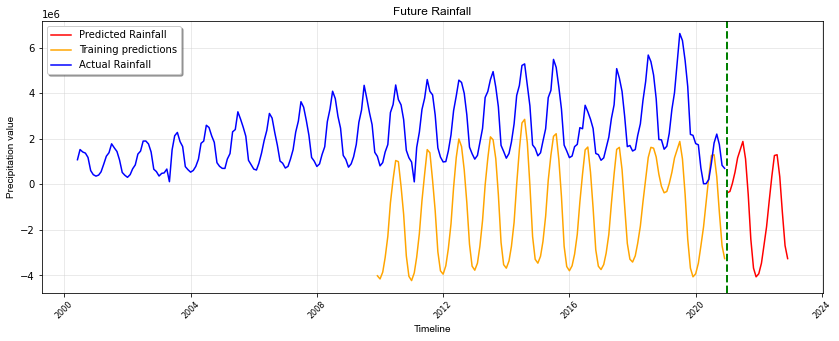

In [13]:
START_DATE_FOR_PLOTTING = '2000-06-01'

# Parse training set timestamp for better visualization
dataset_train = pd.DataFrame(dataset_train, columns=cols)
dataset_train.index = datelist_train
dataset_train.index = pd.to_datetime(dataset_train.index)
plt.plot(PREDICTIONS_FUTURE.index, PREDICTIONS_FUTURE['Total'], color='r', label='Predicted Rainfall')
plt.plot(PREDICTION_TRAIN.loc[START_DATE_FOR_PLOTTING:].index, PREDICTION_TRAIN.loc[START_DATE_FOR_PLOTTING:]['Total'], color='orange', label='Training predictions')
plt.plot(dataset_train.loc[START_DATE_FOR_PLOTTING:].index, dataset_train.loc[START_DATE_FOR_PLOTTING:]['Total'], color='b', label='Actual Rainfall')

plt.axvline(x = min(PREDICTIONS_FUTURE.index), color='green', linewidth=2, linestyle='--')
plt.grid(which='major', color='#cccccc', alpha=0.5)
plt.legend(shadow=True)
plt.title('Future Rainfall', family='Arial', fontsize=12)
plt.xlabel('Timeline', family='Arial', fontsize=10)
plt.ylabel('Precipitation value', family='Arial', fontsize=10)
plt.xticks(rotation=45, fontsize=8)
plt.show()